In [1]:
%load_ext
%autoreload 2

UsageError: Missing module name.


In [2]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from shap import Explainer

from authorship_tool.types_ import AuthorCollection, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import text_reader
from authorship_tool.util.dim_reshaper import reduce_dim
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer, trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import (
    DatasetPaths,
    VijiniDatasetLoocvPaths,
    VijiniDatasetPaths,
)
from authorship_tool.util.serializer import author_collection_to_csv
from authorship_tool.util.tokenizer import tokenize_para

Project root: /workspaces/shap-authorship-analysis-demo
Path: dump/text_data = /workspaces/shap-authorship-analysis-demo/dump/text_data
Path: data/john_blake_2023/wordLists/adjectivesPastParticiple = /workspaces/shap-authorship-analysis-demo/data/john_blake_2023/wordLists/adjectivesPastParticiple
Path: data/john_blake_2023/wordLists/adjectivesPresentParticiple = /workspaces/shap-authorship-analysis-demo/data/john_blake_2023/wordLists/adjectivesPresentParticiple
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017 = /workspaces/shap-authorship-analysis-demo/data/uoa-thesis-2014-2017
Path: dump/processed_text = /workspaces/shap-authorship-analysis-demo/dump/processed_text
Path: dump/dataset = /workspac

In [3]:
fully_generated_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_fully_gen
hybrid_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_hybrid
output_path: Final[Path] = VijiniDatasetPaths.processed_text_dir


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [5]:
DatasetName: TypeAlias = str

full_gen_dataset_files: list[Path] = [
    file
    for file in fully_generated_dataset_path.iterdir()
    if file.with_suffix(".txt").exists()
]
hybrid_dataset_files: list[Path] = [
    file for file in hybrid_dataset_path.iterdir() if file.with_suffix(".txt").exists()
]

dataset_files: list[Path] = sorted(full_gen_dataset_files + hybrid_dataset_files)
dataset_names: list[DatasetName] = [id.name for id in dataset_files]

for idx, file_id in enumerate(dataset_names):
    print(f"#{idx+1}\t{file_id}")


#1	2110.09779_generated.txt
#2	2110.09779_original.txt
#3	2110.10319_generated.txt
#4	2110.10319_original.txt
#5	2110.10329_generated.txt
#6	2110.10329_original.txt
#7	2110.10340_generated.txt
#8	2110.10340_original.txt
#9	2110.10478_generated.txt
#10	2110.10478_original.txt
#11	2110.10575_generated.txt
#12	2110.10575_original.txt
#13	2110.10577_generated.txt
#14	2110.10577_original.txt
#15	2110.10778_generated.txt
#16	2110.10778_original.txt
#17	2110.10817_generated.txt
#18	2110.10817_original.txt
#19	2110.11115_generated.txt
#20	2110.11115_original.txt
#21	2110.11205_generated.txt
#22	2110.11205_original.txt
#23	2110.11207_generated.txt
#24	2110.11207_original.txt
#25	2110.11589_generated.txt
#26	2110.11589_original.txt
#27	2110.11879_generated.txt
#28	2110.11879_original.txt
#29	2110.11984_generated.txt
#30	2110.11984_original.txt
#31	2110.12010_generated.txt
#32	2110.12010_original.txt
#33	2110.12341_generated.txt
#34	2110.12341_original.txt
#35	2110.12383_generated.txt
#36	2110.12

In [6]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for name in dataset_names
    if (match := re.search(r"_(.+?)\.txt", name)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    authors_files: list[Path] = [
        file_id
        for file_id in dataset_files
        if re.match(r".*" + author + r"\.txt$", file_id.name)
    ]

    author_collection: AuthorCollection = text_reader.read_multi_documents(
        authors_files
    )
    doc: Doc3dStr = [tokenize_para(para) for doc in author_collection for para in doc]
    author_para: list[Para2dStr] = [para for para in doc]

    para_num: NumOfParas = len(author_para)
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	original - 292 paragraphs
2:	generated - 290 paragraphs
3:	originalAbstract - 100 paragraphs
4:	generatedAbstract - 100 paragraphs


In [7]:
AUTHOR_A: Final[str] = "original"
AUTHOR_B: Final[str] = "generated"
AUTHOR_C: Final[str] = "generatedAbstract"
AUTHOR_D: Final[str] = "originalAbstract"


In [8]:
Title: TypeAlias = str

files_a: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_A + r"\.txt$", file_id.name)
]

doc_by_title_a: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_a
    for para in text_reader.read_document(file_path)
}


In [9]:
files_b: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_B + r"\.txt$", file_id.name)
]

doc_by_title_b: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_b
    for para in text_reader.read_document(file_path)
}


In [10]:
files_c: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_C + r"\.txt$", file_id.name)
]

doc_by_title_c: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_c
    for para in text_reader.read_document(file_path)
}


In [11]:
files_d: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_D + r"\.txt$", file_id.name)
]

doc_by_title_d: dict[Title, Doc3dStr] = {
    file_path.name: [tokenize_para(para)]
    for file_path in files_d
    for para in text_reader.read_document(file_path)
}


In [12]:
author_collection_to_csv(doc_by_title_a, AUTHOR_A, output_path)
author_collection_to_csv(doc_by_title_b, AUTHOR_B, output_path)
author_collection_to_csv(doc_by_title_c, AUTHOR_C, output_path)
author_collection_to_csv(doc_by_title_d, AUTHOR_D, output_path)


+---------------+-------------------------+--------------------+-------------------+------------+-------------+-----------+---------------+-------------+------------+-----------+----------+-----------+-----------------+---------------+-------------+---------------+-------------+------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+-------------+-----------+-----------+-----------+-------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----

In [13]:
# docs_a, docs_bをlist[Para2dStr]に変換
paras_a: list[Para2dStr] = reduce_dim(tuple(doc_by_title_a.values()))
paras_b: list[Para2dStr] = reduce_dim(tuple(doc_by_title_b.values()))


In [14]:
all_paras: list[Para2dStr] = paras_a + paras_b
all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos
print(all_pos)


['#', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'JJ_presp', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [15]:
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)

dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]


In [17]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]


In [18]:
datasets: pd.DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T


In [19]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)


In [20]:
df = datasets.iloc[:, :-1]
display(df.head(10))


,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,#,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,JJ_presp,LS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,201,201,False,True,False,False,False,6.218253,7.750000,False,True,False,False,False,False,True,False,False,False,False,0.676617,5.746269,0.159204,0.736318,0.159204,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039801,0.044776,0.000000,0.014925,0.004975,0.039801,0.0,0.000000,0.124378,0.154229,0.004975,0.000000,0.0,0.0,0.0,0.014925,0.194030,0.004975,0.000000,0.109453,0.000000,0.0,0.024876,0.019900,0.009950,0.009950,0.000000,0.000000,0.0,0.029851,0.000000,0.044776,0.009950,0.044776,0.029851,0.009950,0.009950,0.000000,0.004975,0.0,0.000000,0.000000
1,99,99,False,True,False,False,False,7.189402,6.666667,False,True,False,False,True,False,False,False,False,False,False,0.707071,6.131313,0.080808,0.787879,0.080808,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.010101,0.040404,0.000000,0.050505,0.000000,0.030303,0.0,0.000000,0.080808,0.191919,0.010101,0.000000,0.0,0.0,0.0,0.000000,0.191919,0.010101,0.000000,0.080808,0.000000,0.0,0.010101,0.030303,0.060606,0.010101,0.000000,0.000000,0.0,0.040404,0.000000,0.040404,0.010101,0.040404,0.020202,0.000000,0.040404,0.000000,0.000000,0.0,0.000000,0.000000
2,165,165,True,True,False,False,False,8.173127,10.750000,False,True,False,False,False,False,True,False,True,True,False,0.612121,6.048485,0.218182,0.727273,0.218182,0.0,0.0,0.0,0.000000,0.018182,0.018182,0.042424,0.030303,0.000000,0.048485,0.012121,0.048485,0.0,0.000000,0.103030,0.127273,0.000000,0.000000,0.0,0.0,0.0,0.018182,0.212121,0.066667,0.000000,0.078788,0.000000,0.0,0.030303,0.000000,0.012121,0.000000,0.000000,0.000000,0.0,0.018182,0.000000,0.036364,0.006061,0.024242,0.006061,0.024242,0.006061,0.006061,0.000000,0.0,0.006061,0.000000
3,649,649,False,True,True,False,False,10.512773,12.250000,True,True,False,True,True,False,True,False,True,True,False,0.454545,4.967643,0.135593,0.639445,0.135593,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.046225,0.038521,0.003082,0.024653,0.003082,0.104777,0.0,0.000000,0.110940,0.095532,0.003082,0.001541,0.0,0.0,0.0,0.012327,0.166410,0.041602,0.000000,0.057011,0.000000,0.0,0.029276,0.007704,0.049307,0.006163,0.000000,0.003082,0.0,0.029276,0.000000,0.035439,0.030817,0.020031,0.036980,0.015408,0.018490,0.001541,0.001541,0.0,0.006163,0.000000
4,767,767,True,True,True,False,False,19.827198,21.000000,True,True,False,True,False,True,True,False,True,True,True,0.353325,4.657106,0.187744,0.654498,0.187744,0.0,0.0,0.0,0.000000,0.016949,0.016949,0.033898,0.028683,0.015645,0.039113,0.010430,0.097784,0.0,0.001304,0.108214,0.117340,0.002608,0.000000,0.0,0.0,0.0,0.009126,0.147327,0.054759,0.000000,0.067797,0.001304,0.0,0.020860,0.001304,0.032595,0.003911,0.000000,0.000000,0.0,0.027379,0.001304,0.035202,0.002608,0.026076,0.024772,0.019557,0.024772,0.003911,0.000000,0.0,0.006519,0.000000
5,174,174,True,True,False,False,False,7.953949,7.666667,False,True,False,False,False,False,True,False,True,True,True,0.609195,5.109195,0.201149,0.718391,0.201149,0.0,0.0,0.0,0.000000,0.011494,0.011494,0.068966,0.040230,0.000000,0.040230,0.011494,0.097701,0.0,0.000000,0.120690,0.114943,0.000000,0.000000,0.0,0.0,0.0,0.005747,0.189655,0.034483,0.000000,0.114943,0.000000,0.0,0.011494,0.000000,0.0172

In [21]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])


array([ True,  True,  True,  True,  True])

In [22]:
print(df.shape)


(200, 73)


In [23]:
print(df.dtypes)


v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [24]:
print(df.isna().sum())


v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [25]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)


In [26]:
result: TrainingResult = trainer.train_once(source)


[LightGBM] [Info] Number of positive: 82, number of negative: 78
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512500 -> initscore=0.050010
[LightGBM] [Info] Start training from score 0.050010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
score: Score | None = result.score


In [28]:
if score is not None:
    print(f"auc-roc score:\t{score.auc_roc_score}")
    print(f"f1 score:\t{score.f1_score}")
    print(f"accuracy score:\t{score.accuracy_score}")

auc-roc score:	0.7373737373737373
f1 score:	0.631578947368421
accuracy score:	0.65


In [29]:

display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))


predicted,False,True
actual,,
False,14,8
True,6,12


In [30]:
dump(result, VijiniDatasetPaths)


In [31]:
test_data: pd.DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.shap_expected_val
shap_vals = result.shap_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0


In [32]:
shap.initjs()


In [33]:
SHAP_FIGURE_DIR: Path = VijiniDatasetPaths.shap_figure_dir


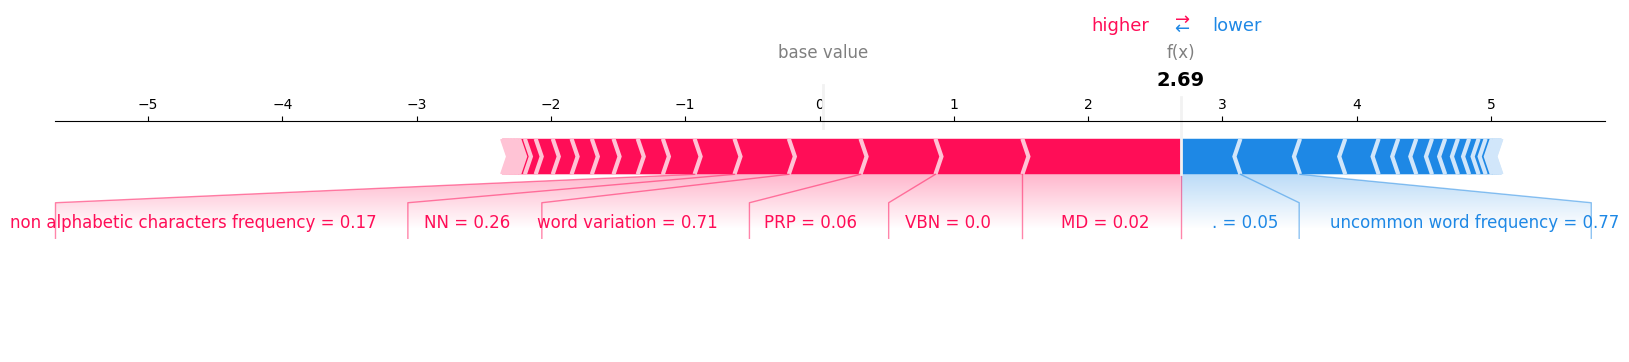

<Figure size 640x480 with 0 Axes>

In [34]:

shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


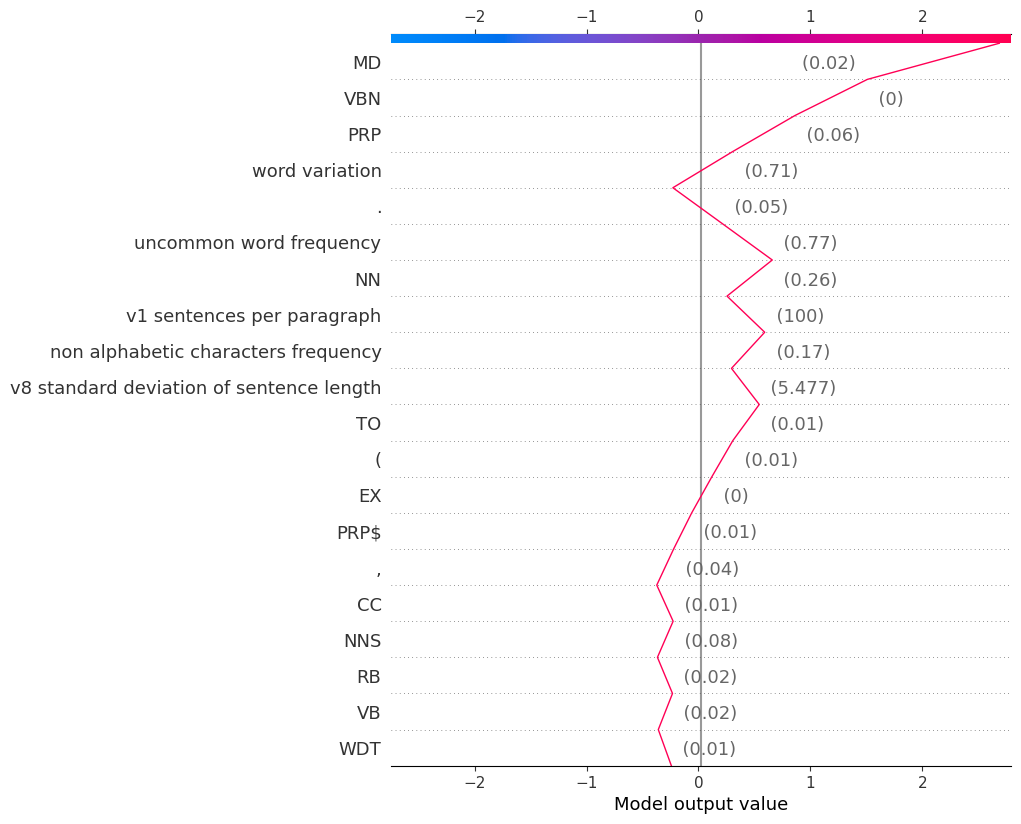

<Figure size 640x480 with 0 Axes>

In [35]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


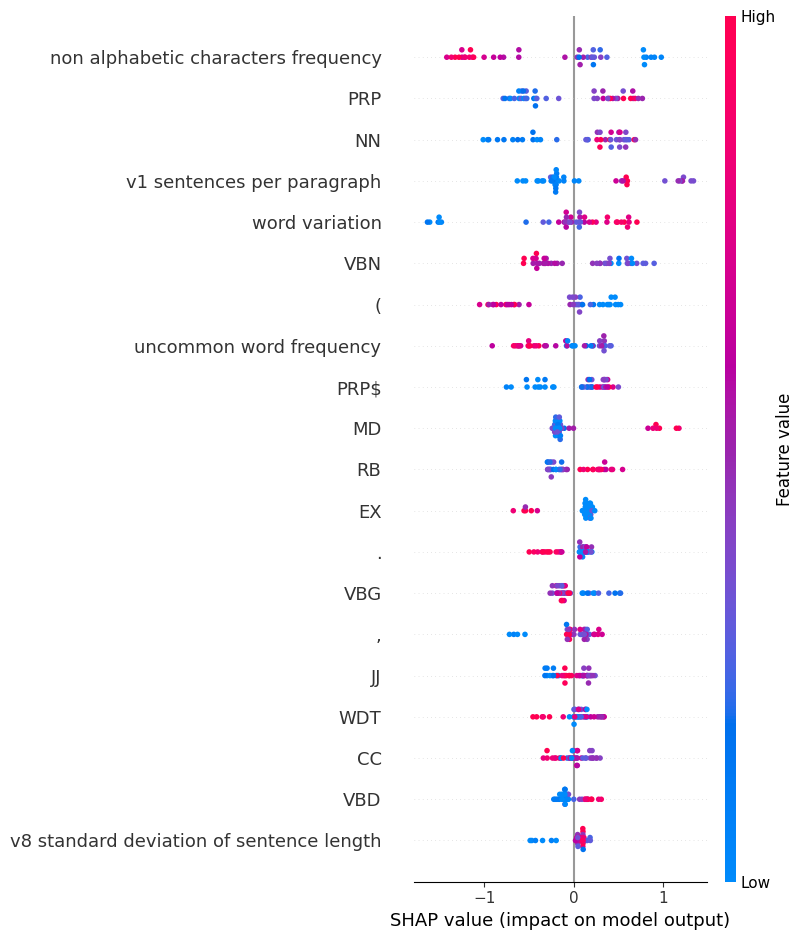

<Figure size 640x480 with 0 Axes>

In [36]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


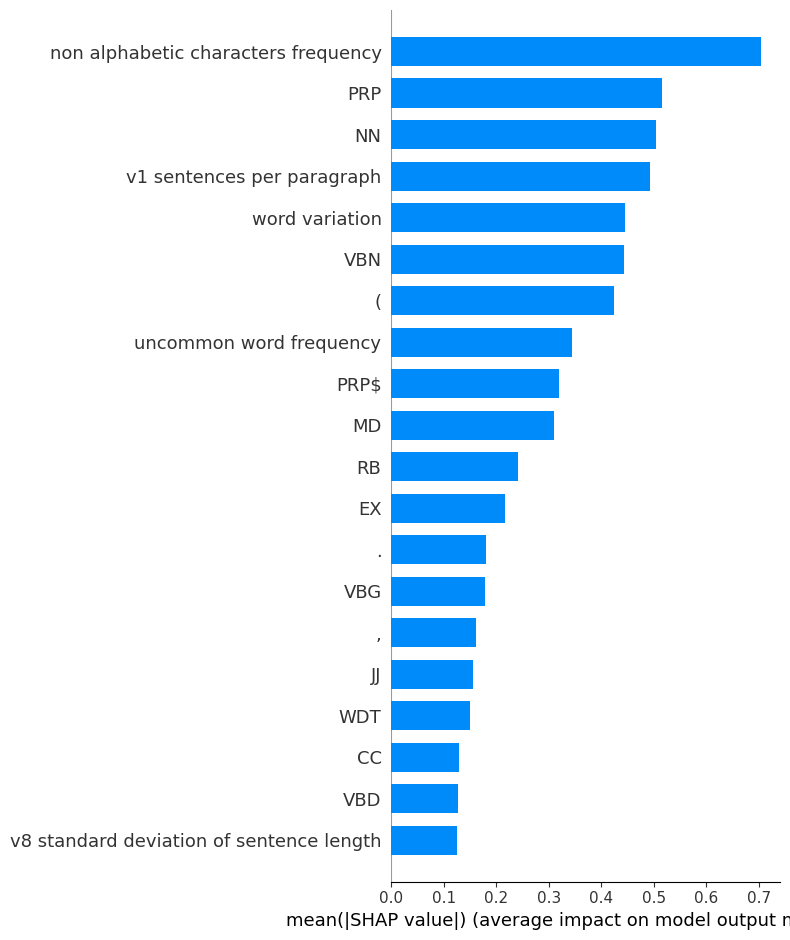

<Figure size 640x480 with 0 Axes>

In [37]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


In [38]:
results_for_each_iters: list[TrainingResult] = cv_trainer.train_loocv(source)


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing ro

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2320
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2320
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [39]:

cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)


In [40]:

cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)


In [41]:

cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)


In [42]:
if cv_score is not None:
    print(f"auc-roc score: {cv_score.auc_roc_score}")
    print(f"f1 score: {cv_score.f1_score}")
    print(f"accuracy score: {cv_score.accuracy_score}")


auc-roc score: 0.6943
f1 score: 0.6634615384615383
accuracy score: 0.65


In [43]:

display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))


predicted,False,True
actual,,
False,61,39
True,31,69


In [44]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals


In [45]:

shap.initjs()


In [46]:

vijini_loocv_figure_dir_path = VijiniDatasetLoocvPaths.shap_figure_dir


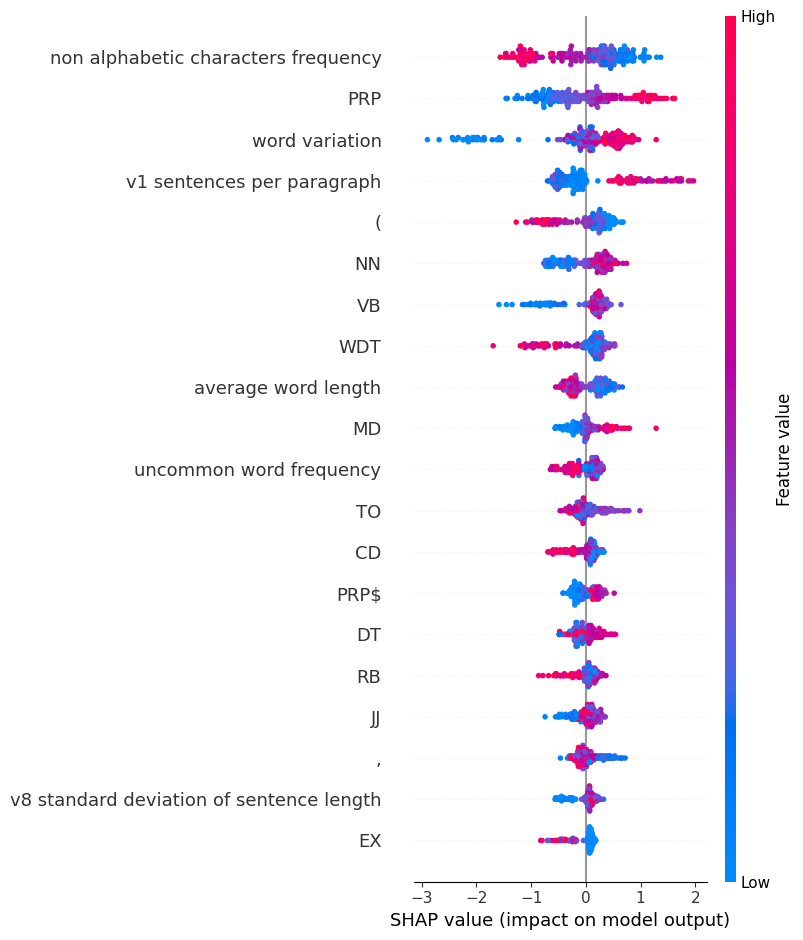

<Figure size 640x480 with 0 Axes>

In [47]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    vijini_loocv_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


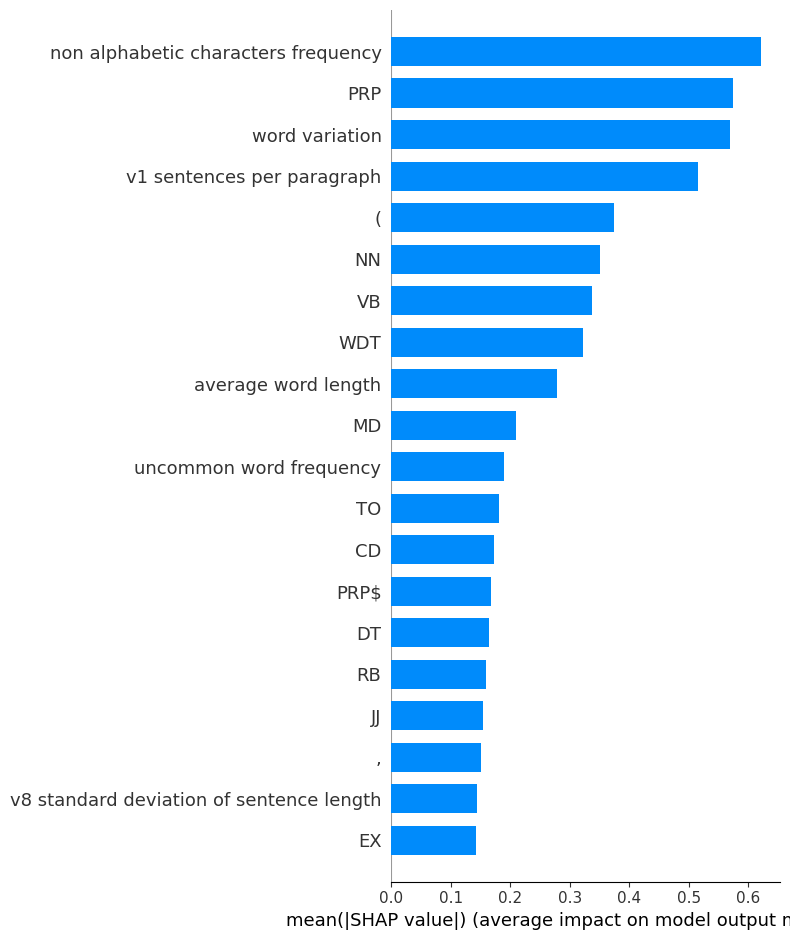

<Figure size 640x480 with 0 Axes>

In [48]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)

plt.savefig(
    vijini_loocv_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
